# Fake News Detection

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import pickle

## exploratory data analysis (EDA)

In [2]:
df_true = pd.read_csv(r"/content/True.csv")
# reads the real news data
df_fake = pd.read_csv(r"/content/Fake.csv")
# Add labels manually
df_true["label"] = "REAL"
df_fake["label"] = "FAKE"# reads the fake news data

df = pd.concat([df_true, df_fake], axis=0)

# Shuffle the data (to mix real and fake randomly)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [3]:
df.sample(6)

,title,text,subject,date,label
3375,Merkel says she would prefer new elections ove...,BERLIN (Reuters) - German Chancellor Angela Me...,worldnews,"November 20, 2017",REAL
35928,HOW THE CLINTON’S GOT RICH Off Donations From ...,In January 2015 a group of Haitians surrounded...,left-news,"Aug 31, 2016",FAKE
40410,"HOW 125,000 ILLEGAL KIDS Have Been Able To Avo...","Did you know that only 3% of the 125,000 illeg...",Government News,"Feb 25, 2016",FAKE
14883,While Scott Baio’s Battle With Erin Moran’s F...,Erin Moran s family members must have really u...,News,"April 28, 2017",FAKE
6670,DETROIT’S AL SHARPTON WANNABE Attempts To Bull...,Never mind the fact that Kid Rock fought for a...,left-news,"Jul 10, 2015",FAKE
8636,U.S. judge deals blow to Texas 'sanctuary' cit...,"AUSTIN, Texas (Reuters) - A U.S. district judg...",politicsNews,"August 10, 2017",REAL


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [5]:
df.shape

(44898, 5)

In [6]:
df.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

In [7]:
df.duplicated().sum()

np.int64(209)

In [8]:
df = df.drop(columns=['title', 'subject', 'date'])


In [9]:
df.sample(3)

,text,label
34308,WELLINGTON (Reuters) - New Zealand s small nat...,REAL
4401,What is with conservatives being all butthurt ...,FAKE
7824,Who knew that members of a presidential admini...,FAKE


## Preprocessing

In [10]:
# lets see whether the data is balanced or imbalanced
df.value_counts('label')

,count
label,
FAKE,23481
REAL,21417


* yes , somewhere it is balanced

### label Encoding ( manually )

In [11]:
df['label'] = df['label'].map({'FAKE': 1, 'REAL': 0})

In [12]:
df.head()

,text,label
0,"Donald Trump s White House is in chaos, and th...",1
1,Now that Donald Trump is the presumptive GOP n...,1
2,Mike Pence is a huge homophobe. He supports ex...,1
3,SAN FRANCISCO (Reuters) - California Attorney ...,0
4,Twisted reasoning is all that comes from Pelos...,1


* Machine learning models can’t understand raw text directly — they need numbers.

* Tokenization splits the text into words or subwords, which can then be converted to numbers

In [13]:
# Tokenize
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['text'])
max_len = 200
X = pad_sequences(sequences, maxlen=max_len)  # input


In [14]:
# input-output split
# X = df['text']
y = df['label']   # output
# y = df['label'].to_numpy() incase

In [15]:
print(X)
print(y)

[[  12    1    2 ...    1  568  502]
 [2118    3   16 ...   26    1  227]
 [  95    2    1 ... 3861  568  502]
 ...
 [   6  586  492 ...  493   50    1]
 [1596   10  616 ...  193 2437   48]
 [   8 1994    6 ...    1    6  297]]
0        1
1        1
2        1
3        0
4        1
        ..
44893    0
44894    1
44895    1
44896    0
44897    0
Name: label, Length: 44898, dtype: int64


## train-test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y )

In [17]:

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(35918, 200) (35918,)
(8980, 200) (8980,)


## Model Building

In [18]:
# Build model

model = Sequential([
    Embedding(5000, 64, input_length=max_len),  # Converts integer sequences into 64-dim vectors
    LSTM(64),                                  # LSTM layer with 64 units to capture sequence info
    Dropout(0.3),                              # Prevent overfitting
    Dense(32, activation='relu'),              # Fully connected layer
    Dense(1, activation='sigmoid')             # Output layer for binary classification
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
model.compile(
    loss='binary_crossentropy',   # suitable for binary classification
    optimizer='adam',             # popular optimizer
    metrics=['accuracy']          # track accuracy
)


In [20]:
# y_train = y_train.to_numpy().reshape(-1,)
# y_test  = y_test.to_numpy().reshape(-1,)


In [21]:
import numpy as np

In [22]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weights)


{0: np.float64(1.04821105468978), 1: np.float64(0.956028746340165)}
Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 105s 183ms/step - accuracy: 0.9150 - loss: 0.2179 - val_accuracy: 0.9861 - val_loss: 0.0512
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 135s 170ms/step - accuracy: 0.9843 - loss: 0.0449 - val_accuracy: 0.9882 - val_loss: 0.0363
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 137s 161ms/step - accuracy: 0.9929 - loss: 0.0227 - val_accuracy: 0.9903 - val_loss: 0.0386
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 143s 164ms/step - accuracy: 0.9967 - loss: 0.0121 - val_accuracy: 0.9892 - val_loss: 0.0353
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 144s 166ms/step - accuracy: 0.9955 - loss: 0.0149 - val_accuracy: 0.9869 - val_loss: 0.0450


In [23]:
# history = model.fit(
#     X_train, y_train,
#     epochs=5,
#     batch_size=64,
#     validation_data=(X_test, y_test)
# )


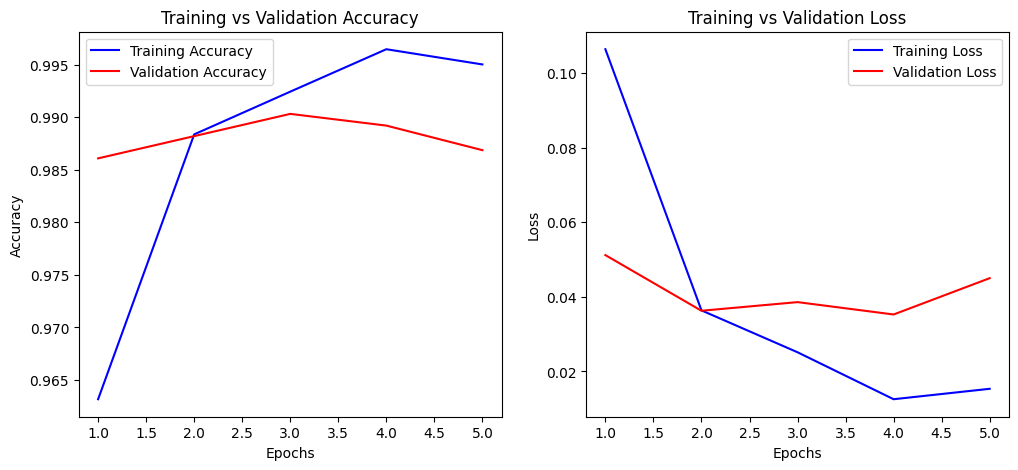

In [24]:
import matplotlib.pyplot as plt

# Extract metrics from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Prediction

In [25]:
# Predict probabilities for X_test
y_pred_prob = model.predict(X_test)

# Convert probabilities to 0 or 1
y_pred = (y_pred_prob >= 0.5).astype(int)

# Example: first 10 predictions
print(y_pred[:10].flatten())
print(y_test[:10])


281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step
[1 0 0 0 0 1 1 1 1 1]
12192    1
535      0
2094     0
1840     0
13037    0
38343    1
9097     1
21542    1
23070    1
26403    1
Name: label, dtype: int64


## Evaluation

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Detailed classification report
print(classification_report(y_test, y_pred, target_names=['REAL','FAKE']))


Test Accuracy: 0.9868596881959911
Confusion Matrix:
 [[4234   50]
 [  68 4628]]
              precision    recall  f1-score   support

        REAL       0.98      0.99      0.99      4284
        FAKE       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



## predict on unseen data

In [28]:
sample = ["WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a â€œfiscal conservativeâ€ on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBSâ€™ â€œFace the Nation,â€ drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense â€œdiscretionaryâ€ spending on programs that support education, scientific research, infrastructure, public health and environmental protection. â€œThe (Trump) administration has already been willing to say: â€˜Weâ€™re going to increase non-defense discretionary spending ... by about 7 percent,â€™â€ Meadows, chairman of the small but influential House Freedom Caucus, said on the program. â€œNow, Democrats are saying thatâ€™s not enough, we need to give the government a pay raise of 10 to 11 percent. For a fiscal conservative, I donâ€™t see where the rationale is. ... Eventually you run out of other peopleâ€™s money,â€ he said. Meadows was among Republicans who voted in late December for their partyâ€™s debt-financed tax overhaul, which is expected to balloon the federal budget deficit and add about $1.5 trillion over 10 years to the $20 trillion national debt. â€œItâ€™s interesting to hear Mark talk about fiscal responsibility,â€ Democratic U.S. Representative Joseph Crowley said on CBS. Crowley said the Republican tax bill would require the  United States to borrow $1.5 trillion, to be paid off by future generations, to finance tax cuts for corporations and the rich. â€œThis is one of the least ... fiscally responsible bills weâ€™ve ever seen passed in the history of the House of Representatives. I think weâ€™re going to be paying for this for many, many years to come,â€ Crowley said. Republicans insist the tax package, the biggest U.S. tax overhaul in more than 30 years,  will boost the economy and job growth. House Speaker Paul Ryan, who also supported the tax bill, recently went further than Meadows, making clear in a radio interview that welfare or â€œentitlement reform,â€ as the party often calls it, would be a top Republican priority in 2018. In Republican parlance, â€œentitlementâ€ programs mean food stamps, housing assistance, Medicare and Medicaid health insurance for the elderly, poor and disabled, as well as other programs created by Washington to assist the needy. Democrats seized on Ryanâ€™s early December remarks, saying they showed Republicans would try to pay for their tax overhaul by seeking spending cuts for social programs. But the goals of House Republicans may have to take a back seat to the Senate, where the votes of some Democrats will be needed to approve a budget and prevent a government shutdown. Democrats will use their leverage in the Senate, which Republicans narrowly control, to defend both discretionary non-defense programs and social spending, while tackling the issue of the â€œDreamers,â€ people brought illegally to the country as children. Trump in September put a March 2018 expiration date on the Deferred Action for Childhood Arrivals, or DACA, program, which protects the young immigrants from deportation and provides them with work permits. The president has said in recent Twitter messages he wants funding for his proposed Mexican border wall and other immigration law changes in exchange for agreeing to help the Dreamers. Representative Debbie Dingell told CBS she did not favor linking that issue to other policy objectives, such as wall funding. â€œWe need to do DACA clean,â€ she said.  On Wednesday, Trump aides will meet with congressional leaders to discuss those issues. That will be followed by a weekend of strategy sessions for Trump and Republican leaders on Jan. 6 and 7, the White House said. Trump was also scheduled to meet on Sunday with Florida Republican Governor Rick Scott, who wants more emergency aid. The House has passed an $81 billion aid package after hurricanes in Florida, Texas and Puerto Rico, and wildfires in California. The package far exceeded the $44 billion requested by the Trump administration. The Senate has not yet voted on the aid. "]
seq = tokenizer.texts_to_sequences(sample)
padded = pad_sequences(seq, maxlen=200)
pred = model.predict(padded)
print(pred)
print("FAKE" if pred > 0.5 else "REAL")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[[0.00021166]]
REAL
